# Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction

*M. Zimmermann, Z. Abbas, K. Dzieciol and N. J. Shah, "Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction," in IEEE Transactions on Medical Imaging, vol. 37, no. 2, pp. 626-637, Feb. 2018, doi: 10.1109/TMI.2017.2771504.*

# Load data

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
import sys

sys.path.insert(0, "../src")

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.mirage import MIRAGE
from juart.recon.monitoring import ConvergenceMonitor
from juart.vis import MultiPlotter

torch.set_num_threads(16)
torch.set_grad_enabled(False)

## Load sequence parameters

In [2]:
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'qrage_info.h5'), 'r') as f:
    num_spokes = f['num_spokes'][...]
    num_sets = f['num_sets'][...]
    num_echoes = f['num_echoes'][...]
    num_partitions_per_block = f['num_partitions_per_block'][...]
    num_autocalibration_lines = f['num_autocalibration_lines'][...]
    acceleration_factor = f['acceleration_factor'][...]
    matrix_size = f['matrix_size'][...]
    readout_bandwidth = f['readout_bandwidth'][...]
    dTI = f['dTI'][...]
    TI0 = f['TI0'][...]
    dTE = f['dTE'][...]
    TE0 = f['TE0'][...]
    TR = f['TR'][...]

In [3]:
nUS = num_spokes
iS = matrix_size[2]//2

In [4]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'
h5_preproc_fname = os.path.join('LocalData', 'Simulations','qrage_grappa_pytorch.h5')
h5_image_fname =  os.path.join('LocalData', 'Simulations','mz_me_mpnrage3d_grappa_%s_%s.h5' % (iS, nUS))

In [5]:
full_h5_preproc_fname = os.path.join(filepath, h5_preproc_fname)
full_h5_image_fname = os.path.join(filepath, h5_image_fname)

In [6]:
print(full_h5_preproc_fname)
print(full_h5_image_fname)

/workspaces/juart-dev/LocalData/Simulations/qrage_grappa_pytorch.h5
/workspaces/juart-dev/LocalData/Simulations/mz_me_mpnrage3d_grappa_4_64.h5


In [7]:
with h5py.File(
    full_h5_preproc_fname,
    "r",
    libver="latest",
    swmr=True,
) as h5_preproc_file:
    nC, nX, nY, nZ, nS = h5_preproc_file["C"].shape[:5]
    nC, spokes, baseresolution, nZ, nS, nTI, nTE = h5_preproc_file["d"].shape

    shape = (nX, nY, nZ, 1, nTI, nTE)

    print("Reconstructing slice %s of %s." % (iS, nS))

    nK = baseresolution * nUS

    # Read data
    C = h5_preproc_file["C"][:, :, :, :, iS : iS + 1, :, :]
    k = h5_preproc_file["k"][:, :nUS, :, :, :, :, :]
    d = h5_preproc_file["d"][:, :nUS, :, :, iS : iS + 1, :, :] / 1e3 / 50

    # nC = 1

    k = k.reshape((2, nK, 1, nTI, nTE))
    d = d.reshape((nC, nK, 1, nTI, nTE))

    C = torch.tensor(C, dtype=torch.complex64)
    k = torch.tensor(k, dtype=torch.float32)
    d = torch.tensor(d, dtype=torch.complex64)

Reconstructing slice 4 of 8.


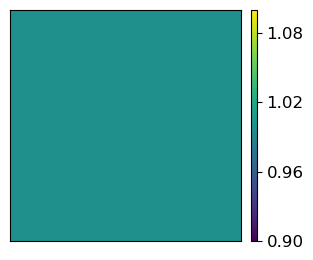

In [8]:
MultiPlotter(
    np.abs(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

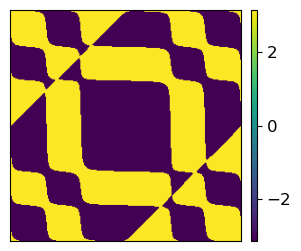

In [9]:
MultiPlotter(
    np.angle(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [10]:
AHd = nonuniform_fourier_transform_adjoint(
    k,
    d,
    (nX, nY),
    modeord=0,
    isign=1,
)
AHd = torch.sum(torch.conj(C) * AHd, dim=0)

In [11]:
H = nonuniform_transfer_function(k, (1, nX, nY, nZ, 1, nTI, nTE), oversampling=(2, 2))

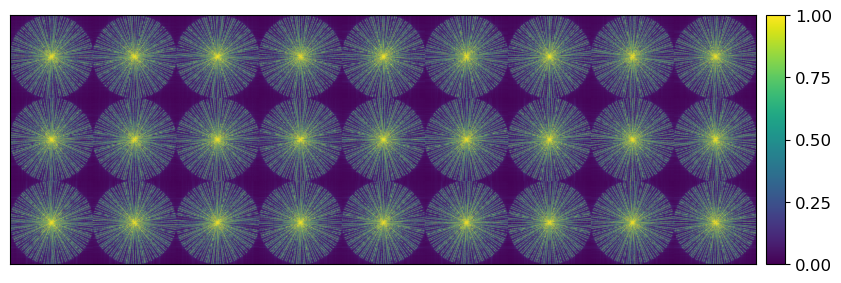

In [12]:
MultiPlotter(
    np.abs(H[0, :, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

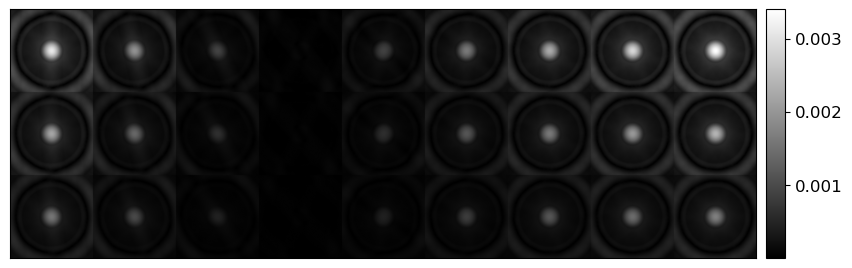

In [13]:
MultiPlotter(
    np.abs(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=0.0125,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

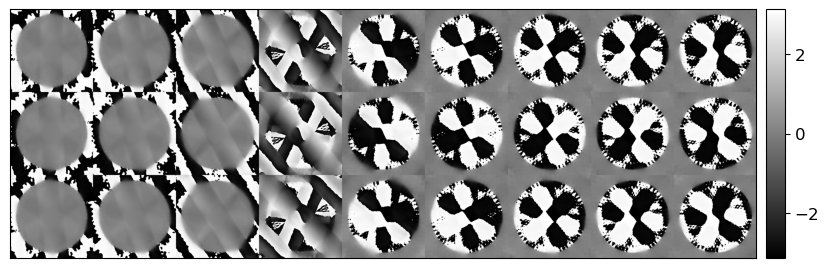

In [14]:
MultiPlotter(
    np.angle(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=-np.pi,
    vmax=np.pi,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [15]:
support = torch.abs(C).max(dim=0).values > 0

cm = ConvergenceMonitor(support + torch.zeros(shape), support, logfile=None)

solver = MIRAGE(
    C[..., 0, 0],
    AHd,
    H,
    lambda_wavelet=1e-3,
    lambda_hankel=None,
    lambda_casorati=None,
    weight_wavelet=1,
    weight_hankel=0.5,
    weight_casorati=0.5,
    cg_maxiter=5,
    admm_maxiter=30,
    callback=cm.callback,
)

[Convergence Monitor] Initialization complete.


In [16]:
# Run MIRAGE reconstruction
solver.solve()

[ADMM] Iter: 00 Prim Res: 3.70E-02 Dual Res: 3.70E-02 Rel Res: 1.00E+00:   3%|▎         | 1/30 [00:03<01:27,  3.03s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  0.000e+00


[ADMM] Iter: 01 Prim Res: 2.81E-02 Dual Res: 7.55E-03 Rel Res: 8.46E-01:   7%|▋         | 2/30 [00:06<01:26,  3.08s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.120e+00


[ADMM] Iter: 02 Prim Res: 1.76E-02 Dual Res: 1.45E-02 Rel Res: 4.91E-01:  10%|█         | 3/30 [00:09<01:22,  3.06s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.036e+00


[ADMM] Iter: 03 Prim Res: 1.07E-02 Dual Res: 1.23E-02 Rel Res: 2.48E-01:  13%|█▎        | 4/30 [00:12<01:19,  3.07s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.080e+00


[ADMM] Iter: 04 Prim Res: 1.02E-02 Dual Res: 7.14E-03 Rel Res: 1.99E-01:  17%|█▋        | 5/30 [00:15<01:16,  3.07s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.071e+00


[ADMM] Iter: 05 Prim Res: 9.38E-03 Dual Res: 2.14E-03 Rel Res: 1.77E-01:  20%|██        | 6/30 [00:18<01:13,  3.07s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.088e+00


[ADMM] Iter: 06 Prim Res: 7.57E-03 Dual Res: 1.99E-03 Rel Res: 1.50E-01:  23%|██▎       | 7/30 [00:21<01:10,  3.08s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.097e+00


[ADMM] Iter: 07 Prim Res: 6.39E-03 Dual Res: 2.85E-03 Rel Res: 1.34E-01:  27%|██▋       | 8/30 [00:24<01:07,  3.09s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.097e+00


[ADMM] Iter: 08 Prim Res: 5.80E-03 Dual Res: 2.27E-03 Rel Res: 1.28E-01:  30%|███       | 9/30 [00:27<01:04,  3.09s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.087e+00


[ADMM] Iter: 09 Prim Res: 5.53E-03 Dual Res: 1.20E-03 Rel Res: 1.25E-01:  33%|███▎      | 10/30 [00:30<01:01,  3.08s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.048e+00


[ADMM] Iter: 10 Prim Res: 5.19E-03 Dual Res: 5.09E-04 Rel Res: 1.18E-01:  37%|███▋      | 11/30 [00:33<00:58,  3.10s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.165e+00


[ADMM] Iter: 11 Prim Res: 4.84E-03 Dual Res: 4.89E-04 Rel Res: 1.10E-01:  40%|████      | 12/30 [00:36<00:55,  3.09s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.049e+00


[ADMM] Iter: 12 Prim Res: 4.58E-03 Dual Res: 5.38E-04 Rel Res: 1.04E-01:  43%|████▎     | 13/30 [00:40<00:52,  3.10s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.135e+00


[ADMM] Iter: 13 Prim Res: 4.33E-03 Dual Res: 4.35E-04 Rel Res: 9.77E-02:  47%|████▋     | 14/30 [00:43<00:49,  3.09s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.076e+00


[ADMM] Iter: 14 Prim Res: 4.04E-03 Dual Res: 4.20E-04 Rel Res: 9.11E-02:  50%|█████     | 15/30 [00:46<00:47,  3.14s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.258e+00


[ADMM] Iter: 15 Prim Res: 3.71E-03 Dual Res: 4.59E-04 Rel Res: 8.38E-02:  53%|█████▎    | 16/30 [00:49<00:43,  3.13s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.088e+00


[ADMM] Iter: 16 Prim Res: 3.39E-03 Dual Res: 4.41E-04 Rel Res: 7.66E-02:  57%|█████▋    | 17/30 [00:52<00:40,  3.11s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.081e+00


[ADMM] Iter: 17 Prim Res: 3.11E-03 Dual Res: 3.68E-04 Rel Res: 7.05E-02:  60%|██████    | 18/30 [00:55<00:37,  3.12s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.119e+00


[ADMM] Iter: 18 Prim Res: 2.89E-03 Dual Res: 2.90E-04 Rel Res: 6.55E-02:  63%|██████▎   | 19/30 [00:58<00:34,  3.10s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.054e+00


[ADMM] Iter: 19 Prim Res: 2.72E-03 Dual Res: 2.20E-04 Rel Res: 6.16E-02:  67%|██████▋   | 20/30 [01:01<00:30,  3.08s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.035e+00


[ADMM] Iter: 20 Prim Res: 2.57E-03 Dual Res: 1.66E-04 Rel Res: 5.82E-02:  70%|███████   | 21/30 [01:04<00:27,  3.06s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.026e+00


[ADMM] Iter: 21 Prim Res: 2.42E-03 Dual Res: 1.39E-04 Rel Res: 5.50E-02:  73%|███████▎  | 22/30 [01:07<00:24,  3.06s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.056e+00


[ADMM] Iter: 22 Prim Res: 2.32E-03 Dual Res: 1.17E-04 Rel Res: 5.26E-02:  77%|███████▋  | 23/30 [01:11<00:21,  3.09s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.172e+00


[ADMM] Iter: 23 Prim Res: 2.23E-03 Dual Res: 9.46E-05 Rel Res: 5.06E-02:  80%|████████  | 24/30 [01:14<00:18,  3.08s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.062e+00


[ADMM] Iter: 24 Prim Res: 2.14E-03 Dual Res: 8.44E-05 Rel Res: 4.87E-02:  83%|████████▎ | 25/30 [01:17<00:15,  3.07s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.038e+00


[ADMM] Iter: 25 Prim Res: 2.07E-03 Dual Res: 8.04E-05 Rel Res: 4.70E-02:  87%|████████▋ | 26/30 [01:20<00:12,  3.06s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.038e+00


[ADMM] Iter: 26 Prim Res: 2.00E-03 Dual Res: 7.25E-05 Rel Res: 4.56E-02:  90%|█████████ | 27/30 [01:23<00:09,  3.06s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.049e+00


[ADMM] Iter: 27 Prim Res: 1.95E-03 Dual Res: 6.49E-05 Rel Res: 4.43E-02:  93%|█████████▎| 28/30 [01:26<00:06,  3.07s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.104e+00


[ADMM] Iter: 28 Prim Res: 1.89E-03 Dual Res: 6.88E-05 Rel Res: 4.30E-02:  97%|█████████▋| 29/30 [01:29<00:03,  3.06s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.030e+00


[ADMM] Iter: 29 Prim Res: 1.84E-03 Dual Res: 7.14E-05 Rel Res: 4.18E-02: 100%|██████████| 30/30 [01:32<00:00,  3.08s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  3.081e+00


tensor([ 2.6821e-07, -1.2875e-07,  1.1952e-07,  ...,  7.4880e-08,
        -1.3530e-07, -7.0579e-08])

In [17]:
z_image = solver.solver.results["v"].view(torch.complex64).reshape(shape)

/tmp/ipykernel_4445/2121847719.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.abs(z_image[..., 0, 0, :, :]),


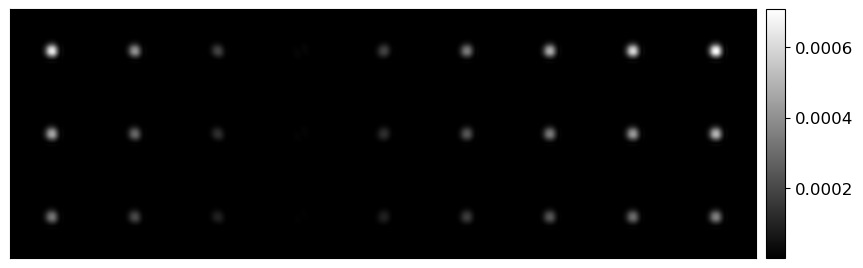

In [18]:
MultiPlotter(
    np.abs(z_image[..., 0, 0, :, :]),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=20,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [19]:
with h5py.File(full_h5_image_fname, "w", libver='latest') as h5_preproc_file:
    dset = h5_preproc_file.create_dataset("x", data=z_image, chunks=(nX, nY, nZ, 1, 1, 1))

In [20]:
# plt.savefig(os.path.join(filepath, 'reconstruction_idea.png'), dpi=1200, transparent=True)